In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('metal.csv', index_col=['date'])
prices.head(10)

TATASTEEL.NS  HINDALCO.NS  JSWSTEEL.NS  ADANIENT.NS     VEDL.NS  \
date                                                                          
01-01-2018    688.066406   271.149994   265.799988    90.480850  325.450012   
02-01-2018    694.830810   271.899994   264.549988    89.309311  327.750000   
03-01-2018    700.213806   276.500000   268.700012    96.011597  332.500000   
04-01-2018    724.318054   279.799988   277.149994    99.880394  339.100006   
05-01-2018    734.274109   276.399994   285.100006   105.247673  339.549988   
08-01-2018    732.416321   276.149994   286.000000   107.045845  340.250000   
09-01-2018    735.798523   271.500000   284.000000   106.746147  337.700012   
10-01-2018    736.322510   268.799988   282.799988   108.326363  334.799988   
11-01-2018    734.512329   267.750000   282.549988   109.906578  333.899994   
12-01-2018    733.845398   268.850006   286.799988   108.953003  339.549988   

            COALINDIA.NS    SAIL.NS  JINDALSTEL.NS     NMDC.NS  APLAPOLLO.NS  
date                                                                          
01-01-2018    266.649994  92.699997     206.199997  141.050003    198.059998  
02-01-2018    270.049988  91.849998     203.399994  148.600006    198.014999  
03-01-2018    271.850006  93.800003     219.550003  149.250000    211.110001  
04-01-2018    277.799988  97.900002     244.550003  154.750000    229.990005  
05-01-2018    278.750000  97.400002     239.050003  158.550003    228.979996  
08-01-2018    287.450012  98.800003     256.450012  161.850006    228.110001  
09-01-2018    304.049988  97.949997     248.750000  154.699997    224.845001  
10-01-2018    308.299988  98.449997     262.399994  155.300003    221.845001  
11-01-2018    308.100006  98.500000     267.350006  155.350006    218.059998  
12-01-2018    309.000000  98.650002     264.850006  154.949997    222.729996

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

TATASTEEL.NS  HINDALCO.NS  JSWSTEEL.NS  ADANIENT.NS     VEDL.NS  \
date                                                                          
01-01-2018    688.066406   271.149994   265.799988    90.480850  325.450012   
02-01-2018    694.830810   271.899994   264.549988    89.309311  327.750000   
30-12-2020    640.450012   237.399994   386.100006   484.149994  162.050003   
31-12-2020    643.650024   240.550003   387.200012   479.549988  161.399994   

            COALINDIA.NS    SAIL.NS  JINDALSTEL.NS     NMDC.NS  APLAPOLLO.NS  
date                                                                          
01-01-2018    266.649994  92.699997     206.199997  141.050003    198.059998  
02-01-2018    270.049988  91.849998     203.399994  148.600006    198.014999  
30-12-2020    135.600006  69.750000     265.950012  115.900002    417.674988  
31-12-2020    135.449997  74.099998     266.450012  114.449997    441.500000

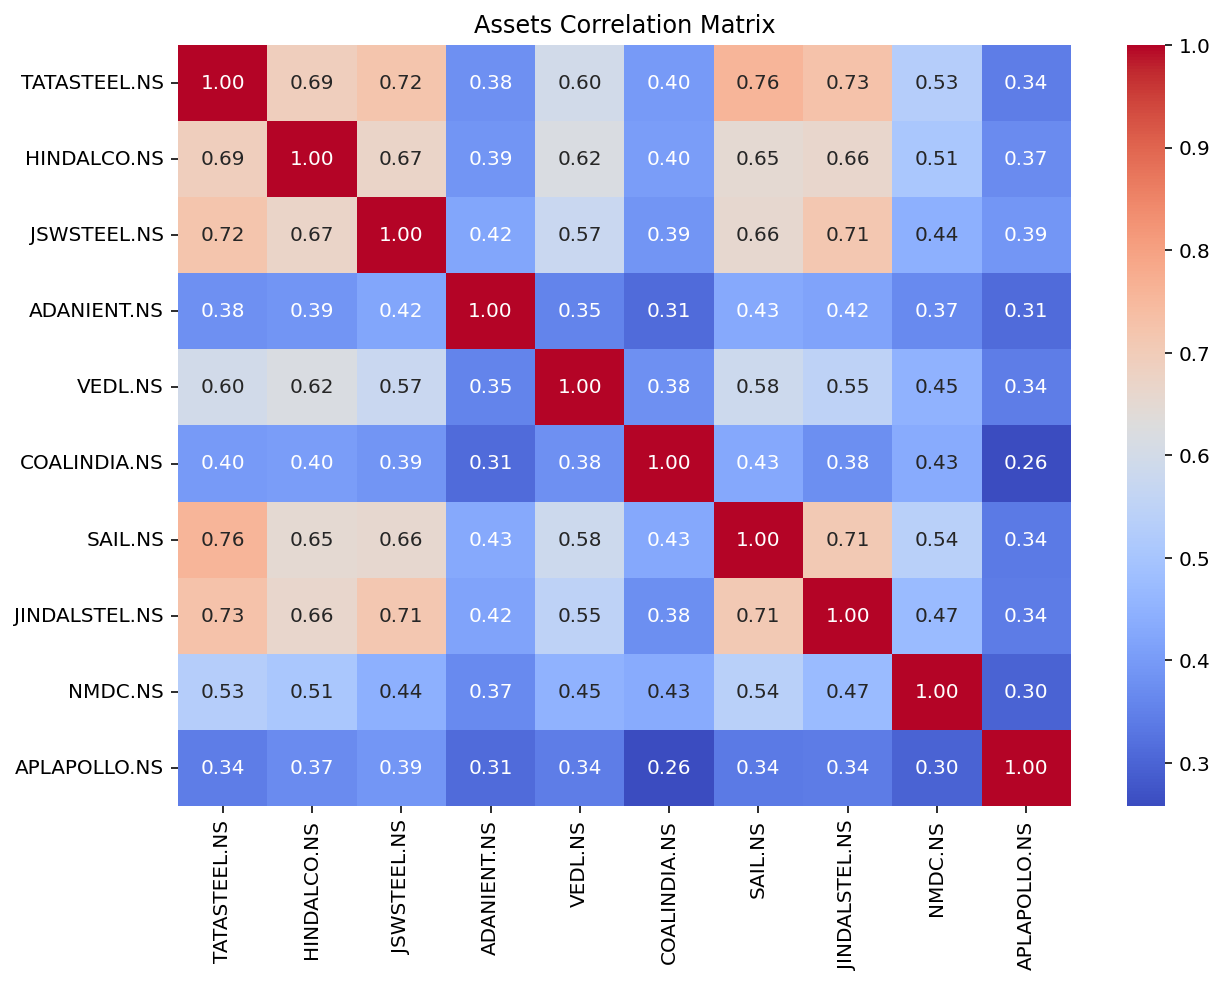

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('TATASTEEL.NS', 'JSWSTEEL.NS'), ('HINDALCO.NS', 'JSWSTEEL.NS')]


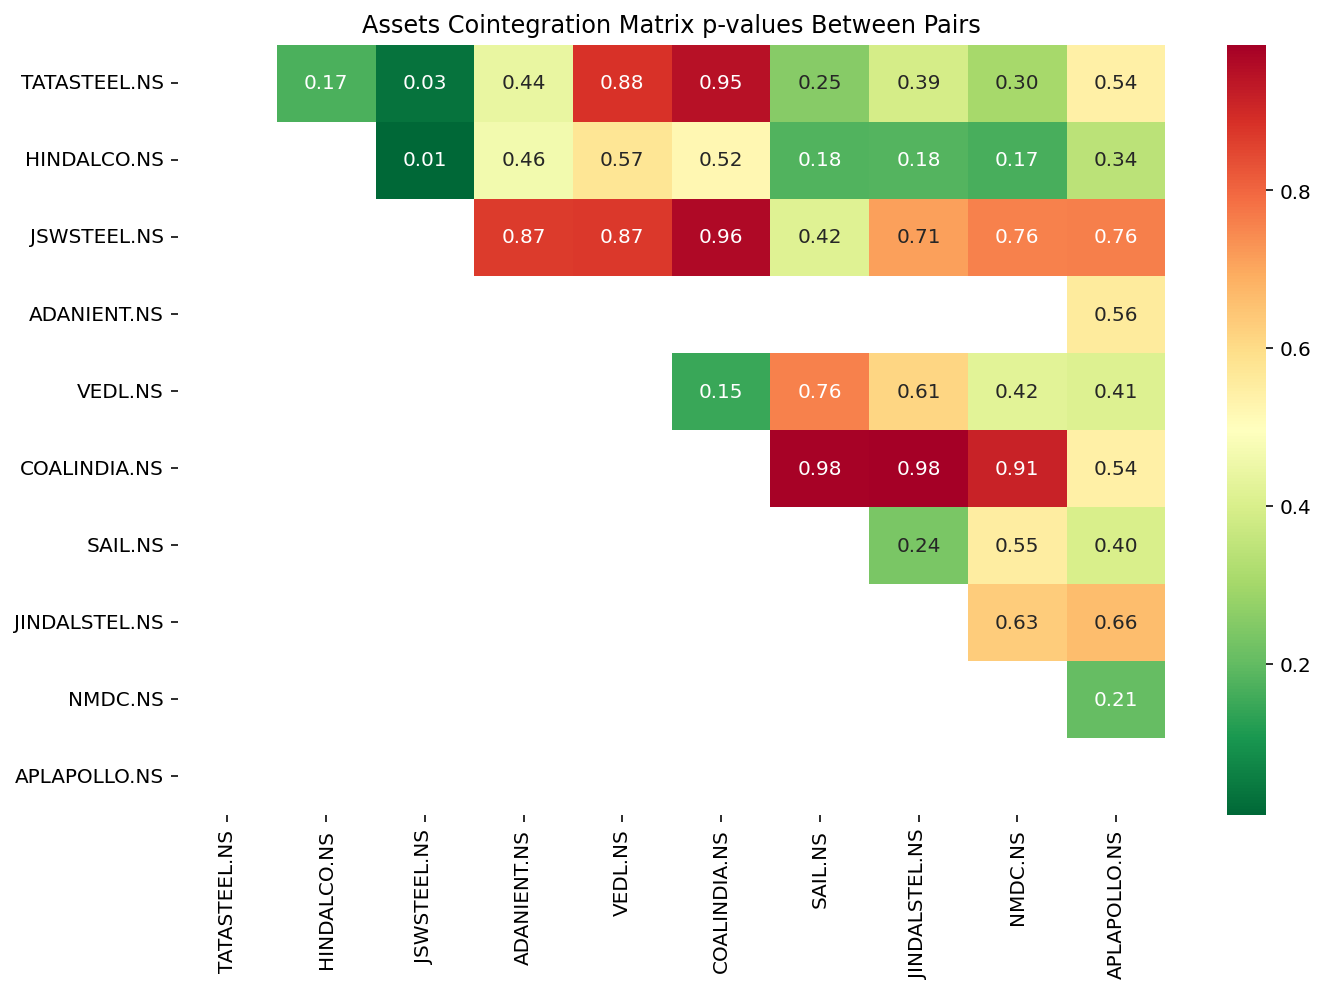

In [7]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [8]:
# final pair to test strategy
asset1 = 'TATASTEEL.NS'
asset2 = 'JSWSTEEL.NS'

In [9]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

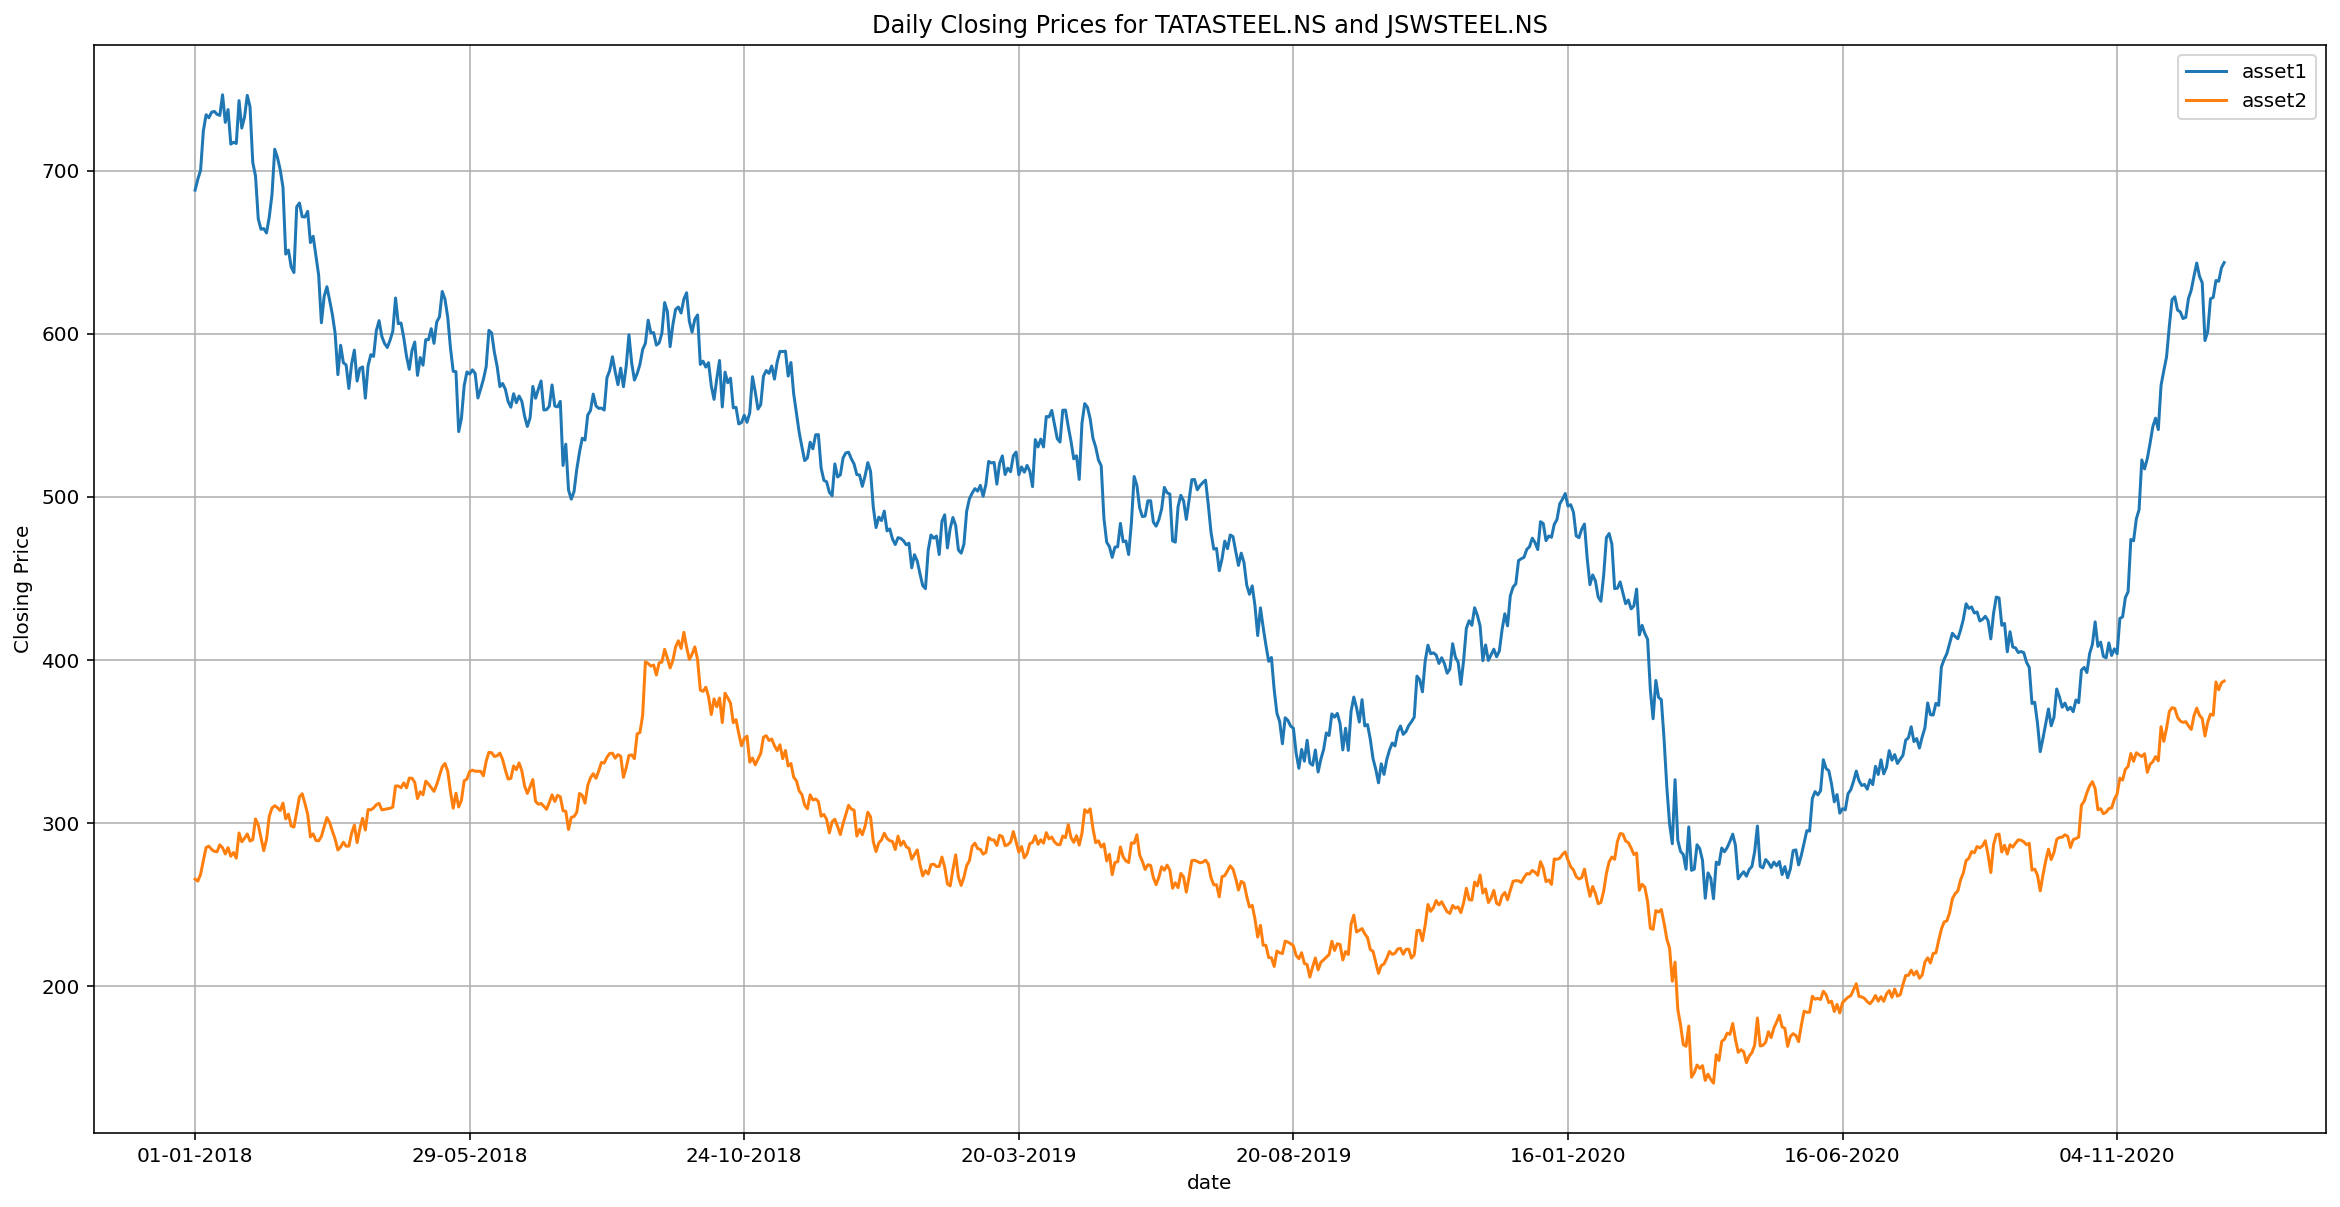

In [10]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(20, 10), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
ax.grid(True);
plt.savefig('chart3', dpi=400) 

In [11]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.982
Model:                            OLS   Adj. R-squared (uncentered):              0.982
Method:                 Least Squares   F-statistic:                          3.943e+04
Date:                Thu, 05 May 2022   Prob (F-statistic):                        0.00
Time:                        09:09:01   Log-Likelihood:                         -3754.5
No. Observations:                 740   AIC:                                      7511.
Df Residuals:                     739   BIC:                                      7516.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         0.5727      0.003    198.559      0.000       0.567       0.578
==============================================================================
Omnibus:                      206.634   Durbin-Watson:                   0.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              671.871
Skew:                          -1.327   Prob(JB):                    1.27e-146
Kurtosis:                       6.840   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

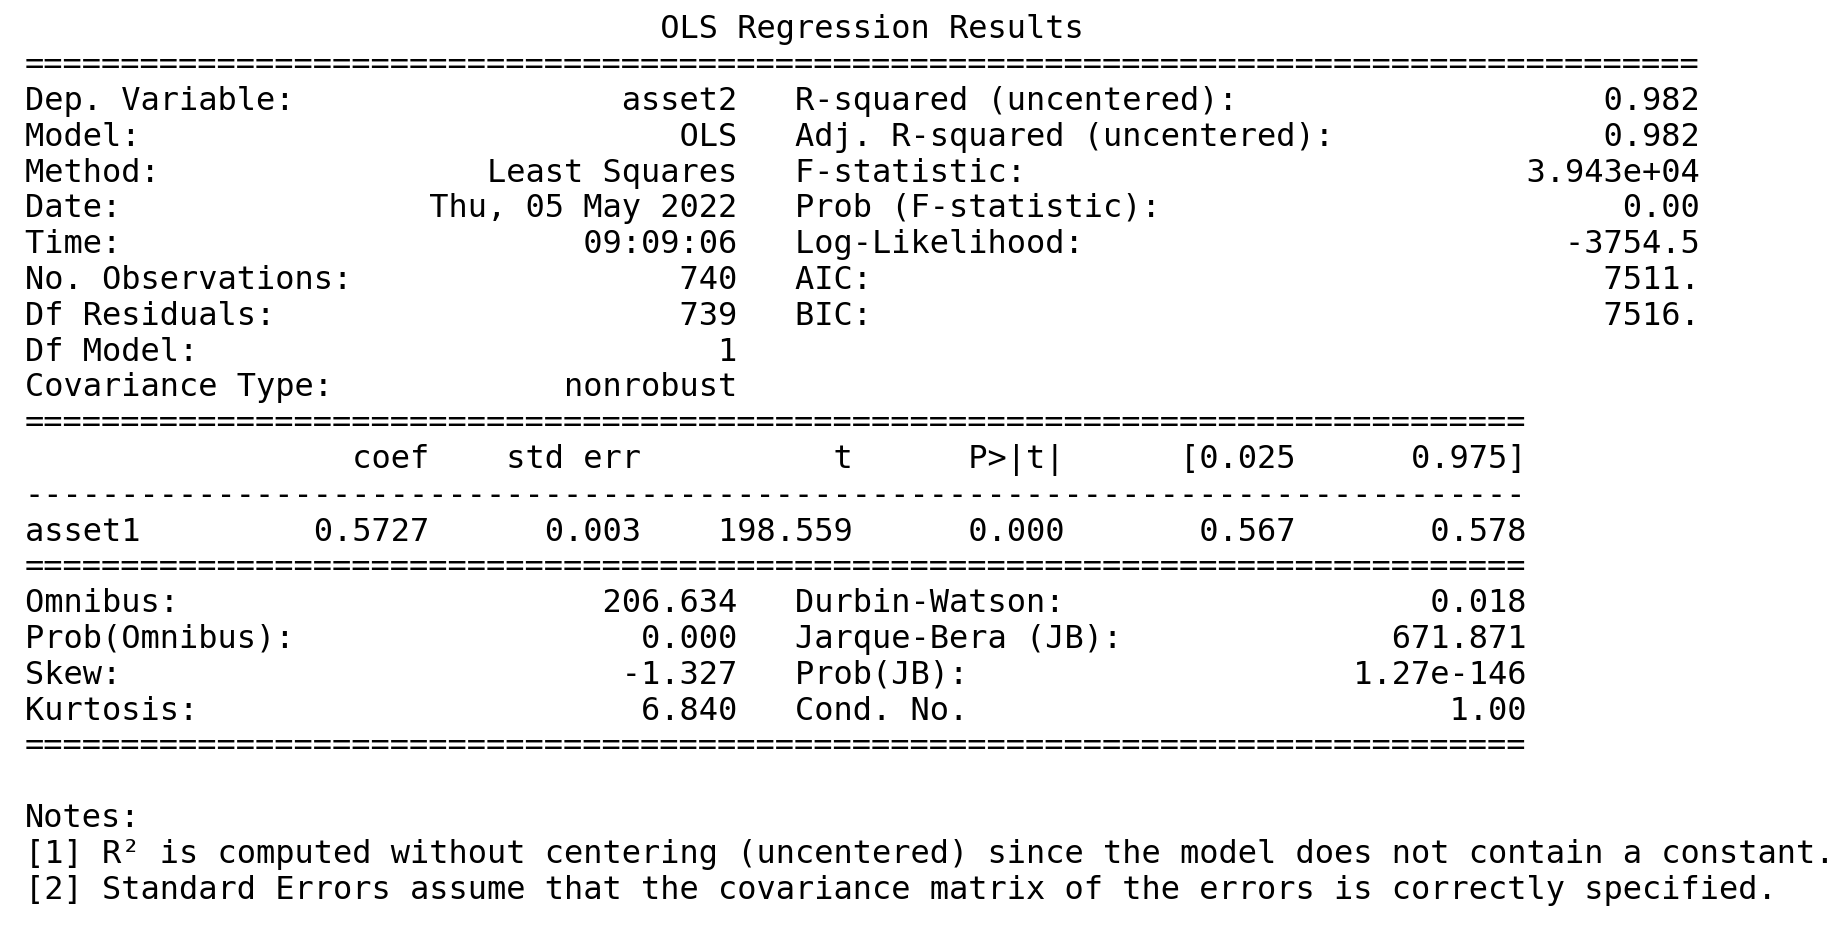

In [13]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [14]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  0.5726832798951836


In [15]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

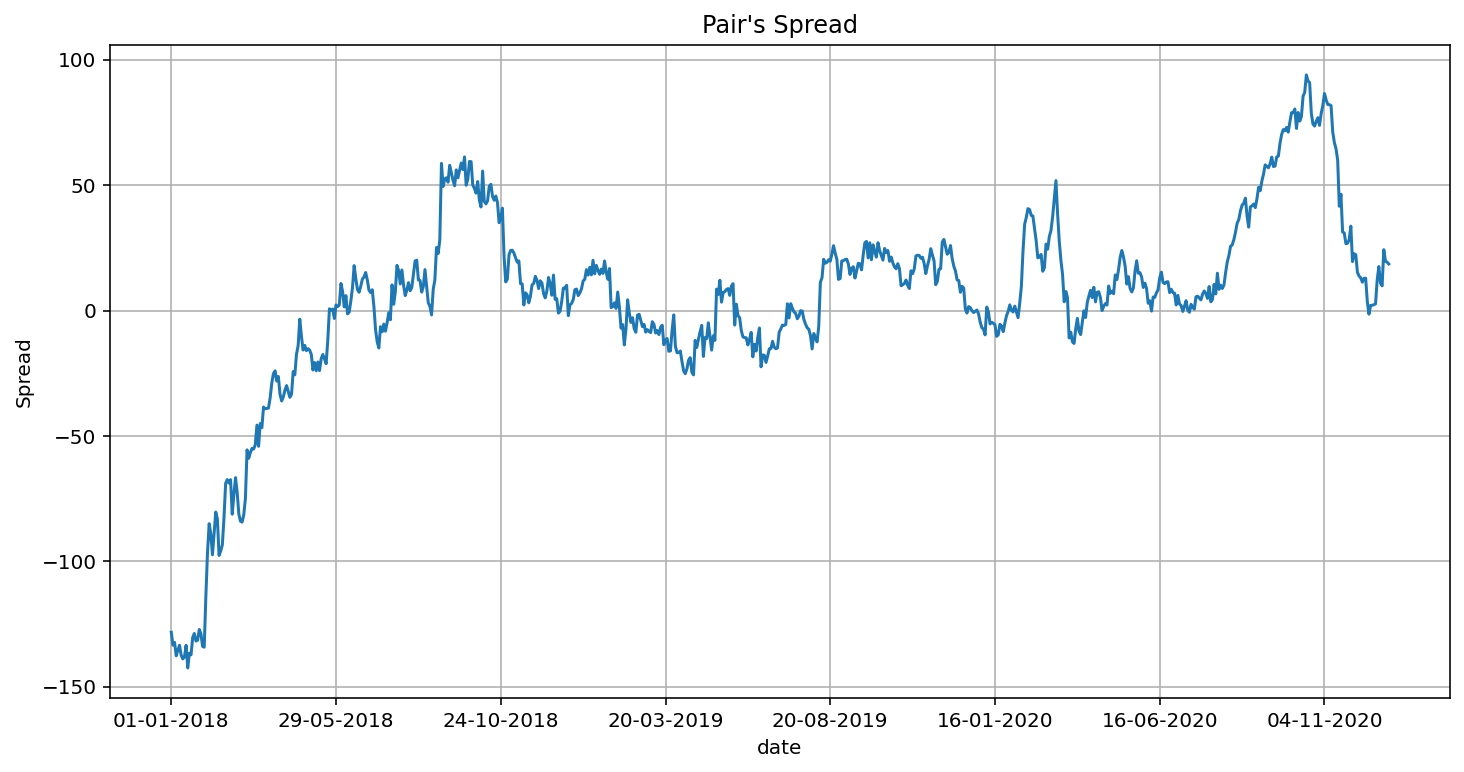

In [16]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('chart5', dpi=400);

In [17]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-3.47616701443559,
 0.008620692096777105,
 0,
 739,
 {'1%': -3.439229783394421,
  '5%': -2.86545894814762,
  '10%': -2.5688568756191392},
 4527.803886397077)

In [18]:
print('Critical Value = ', adf[0])

Critical Value =  -3.47616701443559


In [19]:
# probablity critical values
print(adf[4])

{'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}


### Generate Trading Signals using z-score

In [20]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [21]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [22]:
signals.head()

asset1      asset2
date                              
01-01-2021  643.099976  389.700012
04-01-2021  693.000000  403.100006
05-01-2021  680.549988  395.250000
06-01-2021  683.799988  401.700012
07-01-2021  722.799988  405.399994

In [23]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [24]:
signals.head()

asset1      asset2         z  z upper limit  z lower limit
date                                                                      
01-01-2021  643.099976  389.700012 -0.688727            1.0           -1.0
04-01-2021  693.000000  403.100006 -0.277160            1.0           -1.0
05-01-2021  680.549988  395.250000 -0.261367            1.0           -1.0
06-01-2021  683.799988  401.700012 -0.378129            1.0           -1.0
07-01-2021  722.799988  405.399994  0.103487            1.0           -1.0

In [25]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [26]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

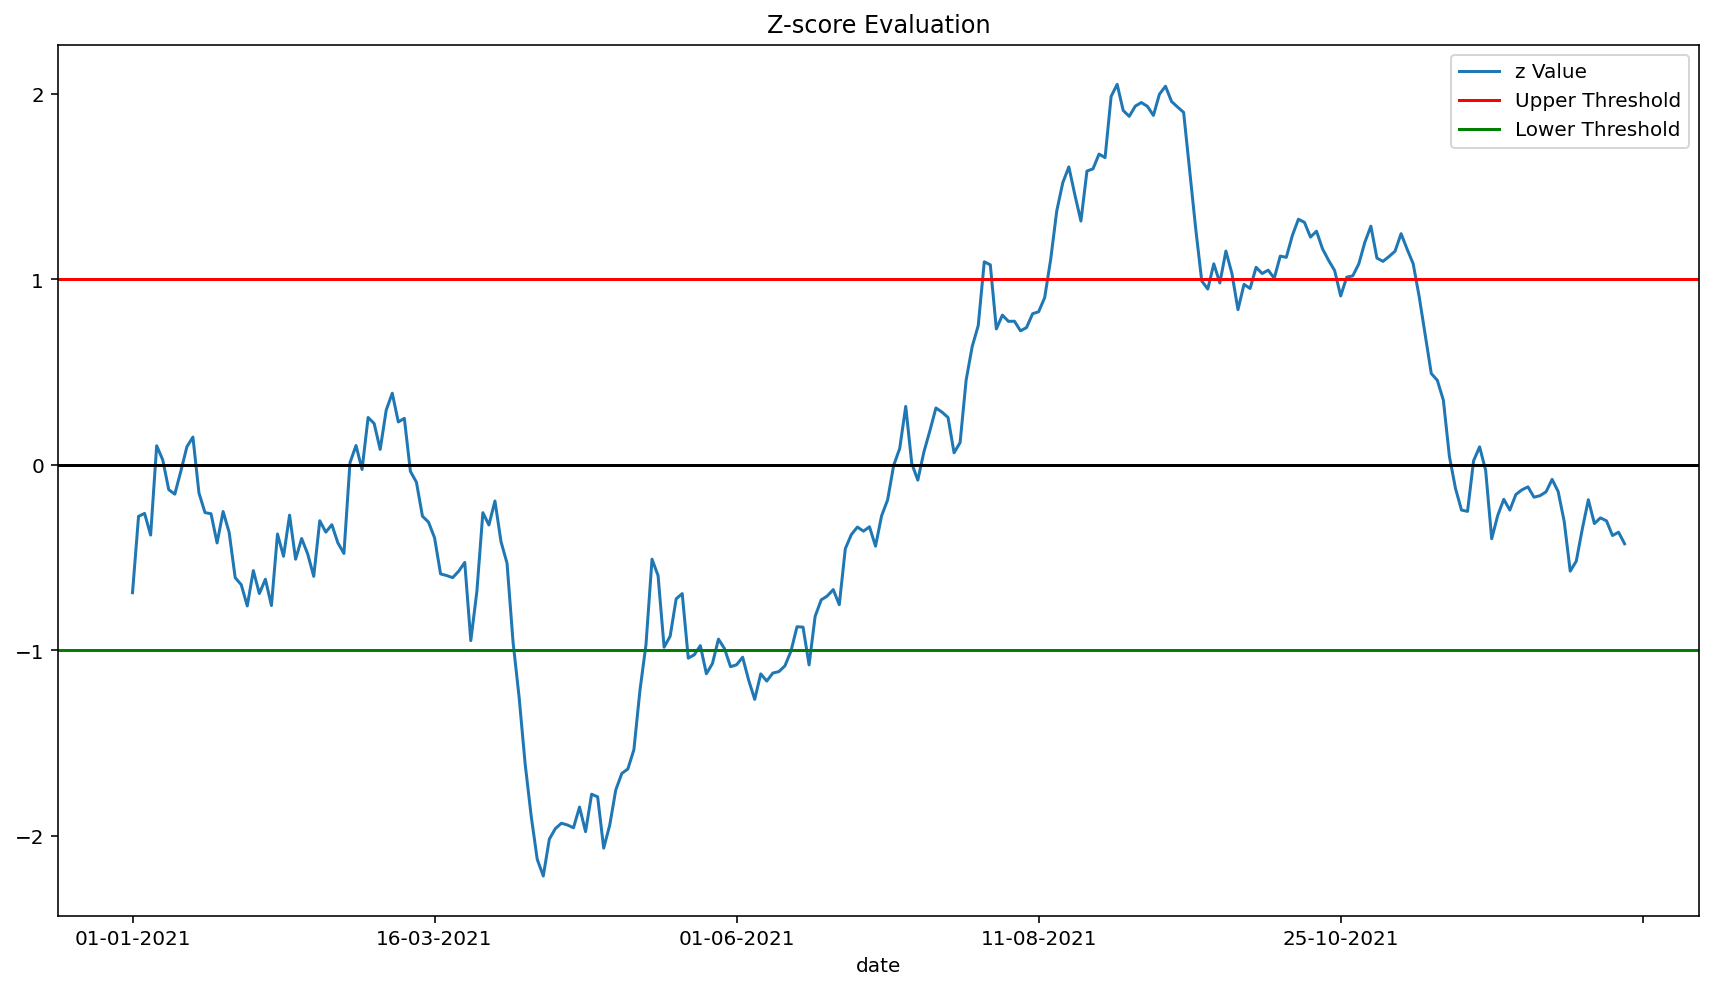

In [27]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evaluation")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=400);

In [28]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021   643.099976  389.700012 -0.688727            1.0           -1.0   
04-01-2021   693.000000  403.100006 -0.277160            1.0           -1.0   
05-01-2021   680.549988  395.250000 -0.261367            1.0           -1.0   
29-12-2021  1116.250000  655.900024 -0.380549            1.0           -1.0   
30-12-2021  1101.000000  645.799988 -0.362624            1.0           -1.0   
31-12-2021  1111.449951  655.950012 -0.425014            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
04-01-2021         0         0.0         0         0.0  
05-01-2021         0         0.0         0         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0

In [29]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
07-04-2021  874.849976  562.299988 -1.252358            1.0           -1.0   
08-04-2021  918.400024  614.099976 -1.612502            1.0           -1.0   
09-04-2021  899.500000  621.000000 -1.893428            1.0           -1.0   
12-04-2021  851.549988  604.150024 -2.126097            1.0           -1.0   
13-04-2021  879.000000  630.349976 -2.215879            1.0           -1.0   
15-04-2021  898.200012  629.099976 -2.017115            1.0           -1.0   
16-04-2021  890.250000  619.400024 -1.960252            1.0           -1.0   
19-04-2021  888.049988  615.799988 -1.931415            1.0           -1.0   
20-04-2021  894.000000  620.599976 -1.940767            1.0           -1.0   
22-04-2021  921.400024  640.750000 -1.955927            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
07-04-2021         1         1.0        -1        -1.0  
08-04-2021         1         0.0        -1         0.0  
09-04-2021         1         0.0        -1         0.0  
12-04-2021         1         0.0        -1         0.0  
13-04-2021         1         0.0        -1         0.0  
15-04-2021         1         0.0        -1         0.0  
16-04-2021         1         0.0        -1         0.0  
19-04-2021         1         0.0        -1         0.0  
20-04-2021         1         0.0        -1         0.0  
22-04-2021         1         0.0        -1         0.0

In [30]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021   643.099976  389.700012 -0.688727            1.0           -1.0   
07-04-2021   874.849976  562.299988 -1.252358            1.0           -1.0   
10-05-2021  1216.349976  758.650024 -0.968957            1.0           -1.0   
20-05-2021  1105.050049  694.500000 -1.041581            1.0           -1.0   
24-05-2021  1092.000000  681.450012 -0.973991            1.0           -1.0   
29-09-2021  1295.550049  679.799988  0.836976            1.0           -1.0   
04-10-2021  1324.150024  681.150024  1.065114            1.0           -1.0   
25-10-2021  1293.300049  674.250000  0.910713            1.0           -1.0   
26-10-2021  1343.650024  694.349976  1.012140            1.0           -1.0   
12-11-2021  1287.250000  671.349976  0.906378            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
07-04-2021         1         1.0        -1        -1.0  
10-05-2021         0        -1.0         0         1.0  
20-05-2021         1         1.0        -1        -1.0  
24-05-2021         0        -1.0         0         1.0  
29-09-2021         0         1.0         0        -1.0  
04-10-2021        -1        -1.0         1         1.0  
25-10-2021         0         1.0         0        -1.0  
26-10-2021        -1        -1.0         1         1.0  
12-11-2021         0         1.0         0        -1.0

In [31]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

874.849976     1
1105.050049    1
1105.199951    1
1125.650024    1
1103.750000    1
1410.050049    1
1292.199951    1
1272.099976    1
1295.550049    1
1293.300049    1
1287.250000    1
Name: asset1, dtype: int64

In [32]:
signals

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021   643.099976  389.700012 -0.688727            1.0           -1.0   
04-01-2021   693.000000  403.100006 -0.277160            1.0           -1.0   
05-01-2021   680.549988  395.250000 -0.261367            1.0           -1.0   
06-01-2021   683.799988  401.700012 -0.378129            1.0           -1.0   
07-01-2021   722.799988  405.399994  0.103487            1.0           -1.0   
...                 ...         ...       ...            ...            ...   
27-12-2021  1121.800049  653.049988 -0.285462            1.0           -1.0   
28-12-2021  1127.449951  657.349976 -0.301235            1.0           -1.0   
29-12-2021  1116.250000  655.900024 -0.380549            1.0           -1.0   
30-12-2021  1101.000000  645.799988 -0.362624            1.0           -1.0   
31-12-2021  1111.449951  655.950012 -0.425014            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
04-01-2021         0         0.0         0         0.0  
05-01-2021         0         0.0         0         0.0  
06-01-2021         0         0.0         0         0.0  
07-01-2021         0         0.0         0         0.0  
...              ...         ...       ...         ...  
27-12-2021         0         0.0         0         0.0  
28-12-2021         0         0.0         0         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0  

[248 rows x 9 columns]

In [33]:
signals = signals.reset_index()

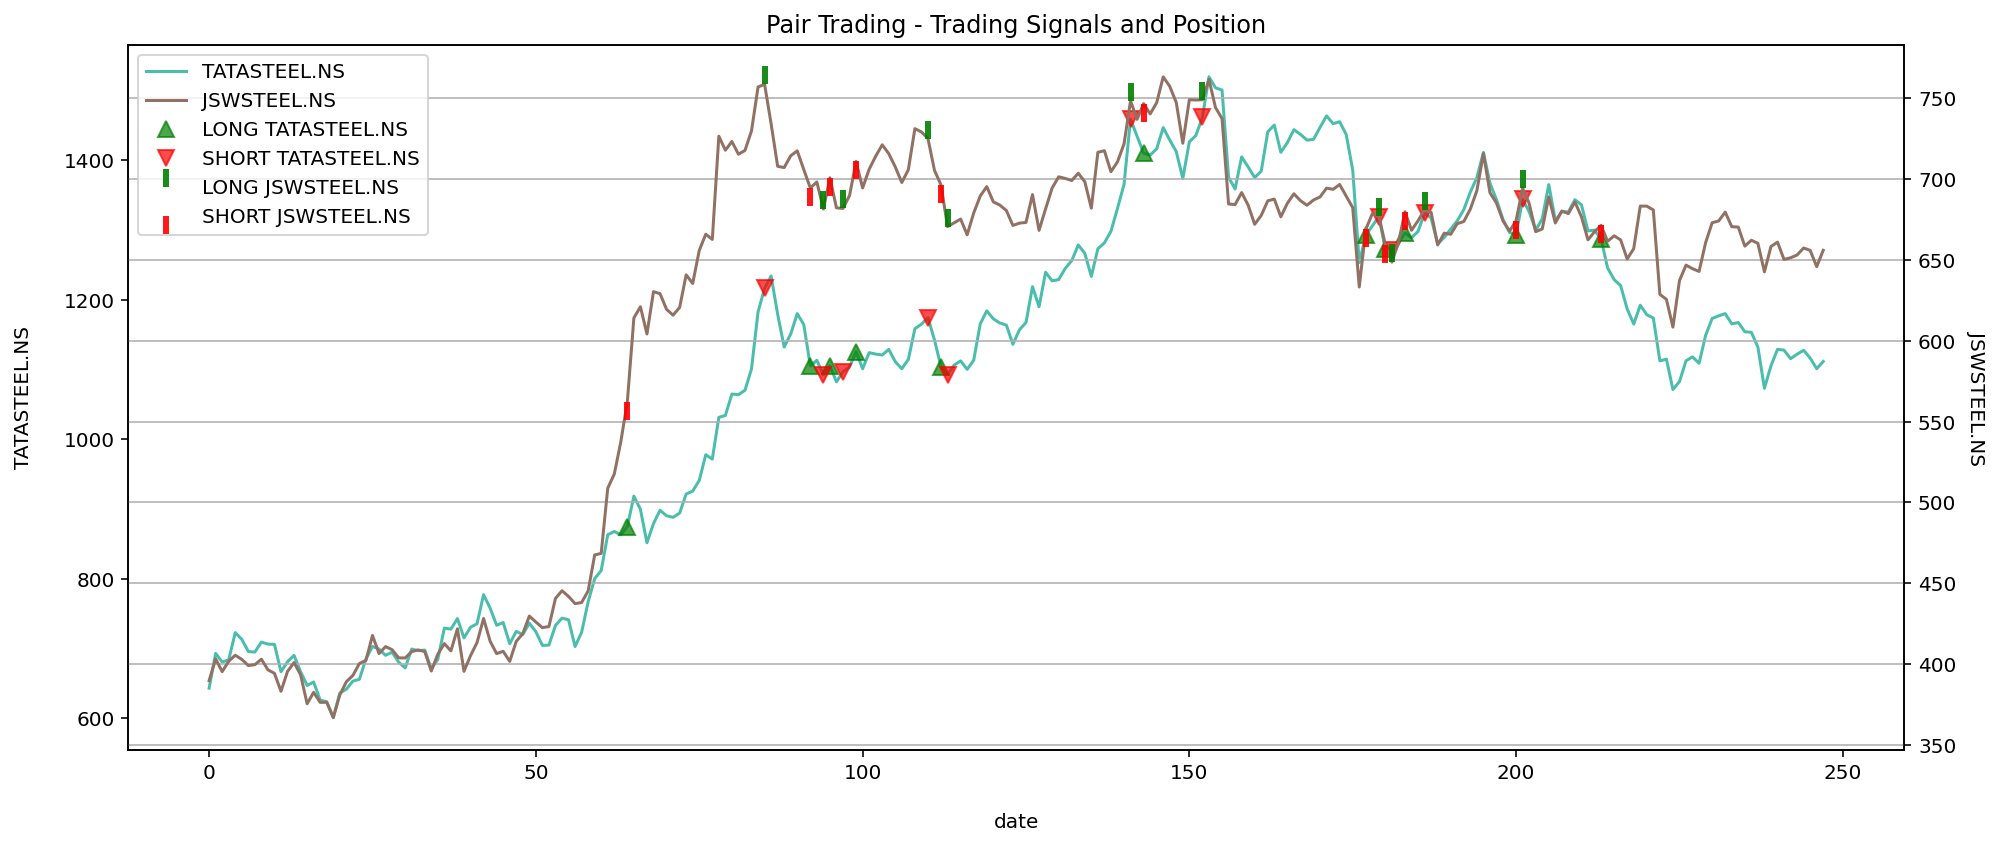

In [34]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=400);

### Portfolio Profit and Loss Calculation

In [35]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [36]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [37]:
portfolio.head().append(portfolio.tail())

asset1  holdings1          cash1   total asset1  return1  positions1
0     643.099976        NaN            NaN            NaN      NaN         NaN
1     693.000000        0.0  100000.000000  100000.000000      NaN         0.0
2     680.549988        0.0  100000.000000  100000.000000      0.0         0.0
3     683.799988        0.0  100000.000000  100000.000000      0.0         0.0
4     722.799988        0.0  100000.000000  100000.000000      0.0         0.0
243  1121.800049        0.0  144453.501521  144453.501521      0.0         0.0
244  1127.449951        0.0  144453.501521  144453.501521      0.0         0.0
245  1116.250000        0.0  144453.501521  144453.501521      0.0         0.0
246  1101.000000        0.0  144453.501521  144453.501521      0.0         0.0
247  1111.449951        0.0  144453.501521  144453.501521      0.0         0.0

In [38]:
portfolio[portfolio.positions1 != 0].head()

asset1     holdings1          cash1   total asset1   return1  \
0    643.099976           NaN            NaN            NaN       NaN   
64   874.849976  56865.248414   43134.751586  100000.000000  0.000000   
85  1216.349976      0.000000  122197.500026  122197.500026  0.018419   
92  1105.050049  71828.253185   50369.246841  122197.500026  0.000000   
94  1092.000000      0.000000  121349.246841  121349.246841 -0.011176   

    positions1  
0          NaN  
64         1.0  
85        -1.0  
92         1.0  
94        -1.0

In [39]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [40]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1  holdings1          cash1   total asset1  return1  \
0     643.099976        NaN            NaN            NaN      NaN   
1     693.000000        0.0  100000.000000  100000.000000      NaN   
2     680.549988        0.0  100000.000000  100000.000000      0.0   
3     683.799988        0.0  100000.000000  100000.000000      0.0   
4     722.799988        0.0  100000.000000  100000.000000      0.0   
243  1121.800049        0.0  144453.501521  144453.501521      0.0   
244  1127.449951        0.0  144453.501521  144453.501521      0.0   
245  1116.250000        0.0  144453.501521  144453.501521      0.0   
246  1101.000000        0.0  144453.501521  144453.501521      0.0   
247  1111.449951        0.0  144453.501521  144453.501521      0.0   

     positions1      asset2  holdings2          cash2   total asset2  return2  \
0           NaN  389.700012        NaN            NaN            NaN      NaN   
1           0.0  403.100006        0.0  100000.000000  100000.000000      NaN   
2           0.0  395.250000        0.0  100000.000000  100000.000000      0.0   
3           0.0  401.700012        0.0  100000.000000  100000.000000      0.0   
4           0.0  405.399994        0.0  100000.000000  100000.000000      0.0   
243         0.0  653.049988        0.0   67060.048402   67060.048402      0.0   
244         0.0  657.349976        0.0   67060.048402   67060.048402      0.0   
245         0.0  655.900024        0.0   67060.048402   67060.048402      0.0   
246         0.0  645.799988        0.0   67060.048402   67060.048402      0.0   
247         0.0  655.950012        0.0   67060.048402   67060.048402      0.0   

     positions2  
0           NaN  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
243         0.0  
244         0.0  
245         0.0  
246         0.0  
247         0.0

In [41]:
portfolio[portfolio.positions2 != 0].head()

asset1     holdings1          cash1   total asset1   return1  \
0    643.099976           NaN            NaN            NaN       NaN   
64   874.849976  56865.248414   43134.751586  100000.000000  0.000000   
85  1216.349976      0.000000  122197.500026  122197.500026  0.018419   
92  1105.050049  71828.253185   50369.246841  122197.500026  0.000000   
94  1092.000000      0.000000  121349.246841  121349.246841 -0.011176   

    positions1      asset2     holdings2          cash2   total asset2  \
0          NaN  389.700012           NaN            NaN            NaN   
64         1.0  562.299988 -73661.298402  173661.298402  100000.000000   
85        -1.0  758.650024      0.000000   74278.145205   74278.145205   
92         1.0  694.500000 -90979.500000  165257.645205   74278.145205   
94        -1.0  681.450012      0.000000   75987.693607   75987.693607   

     return2  positions2  
0        NaN         NaN  
64  0.000000        -1.0  
85 -0.002989         1.0  
92  0.000000        -1.0  
94  0.029735         1.0

In [42]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

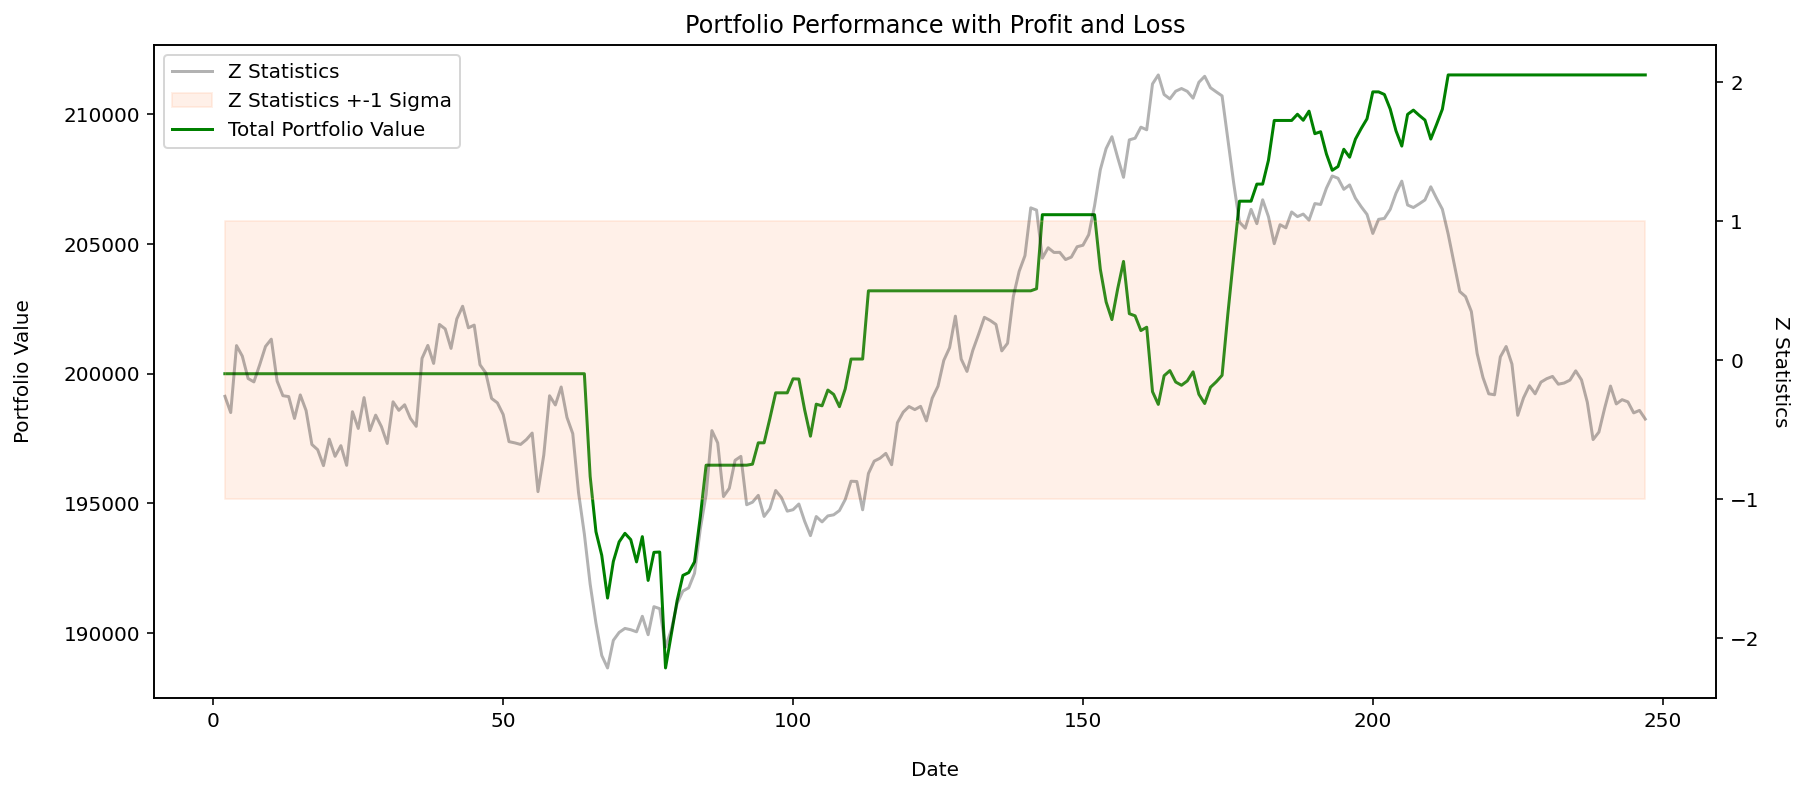

In [43]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=400);

In [44]:
#portfolio = pd.read_csv('portfolio.csv')

In [45]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

211513.5499228

In [46]:
profit = final_portfolio - 2*initial_capital
profit

11513.549922800012

In [47]:
roi = (profit/(2*initial_capital))*100
roi

5.756774961400006

In [ ]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

In [46]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 205.272%
